In [2]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna as op
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
def euclidean_distance(X: np.array, Y: np.array):
    return np.sqrt(np.sum((X - Y) ** 2))

def cosine_distance(X: np.array, Y: np.array):
    return 1 - np.dot(X, Y) / (np.sqrt(np.dot(Y, Y)) * np.sqrt(np.dot(X, X)))

def manhattan_distance(X: np.array, Y: np.array):
    return np.sum(np.abs(X - Y))

def uniform(a: np.array):
    return (np.float64(0.5) * a) * (np.abs(a) < 1.0)

def triangular_kernel(a: np.array):
    return (1 - np.abs(a)) * (np.abs(a) < 1.0)


def epanechnikov_kernel(a: np.array):
    return (3 / 4 * (1 - a ** 2)) * (np.abs(a) < 1.0)


def gaussian_kernel(a: np.array):
    return 1.0 / np.sqrt(2.0 * np.pi) * np.exp((a ** 2) / -2.0)


# loading data

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


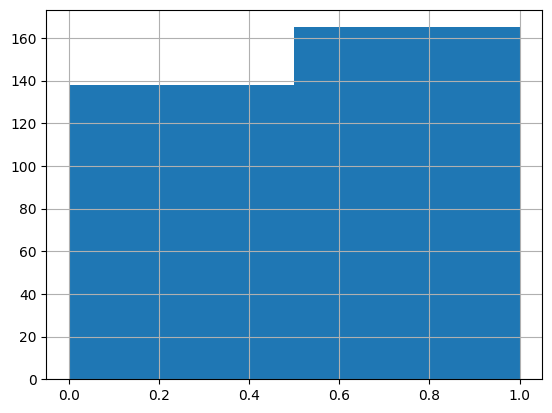

In [4]:
df = pd.read_csv("heart.csv", sep=',')

diagnosis_classes = df["output"] 

data = StandardScaler().fit_transform(df.drop(columns=['output']).to_numpy())

(X_train, X_test,
 Y_train, Y_test) = train_test_split(data, diagnosis_classes.to_numpy(), test_size=0.40, random_state=42)
df['output'].hist(bins=2)
df



# KNN main code

In [43]:
class KNNImplementation(object):
    def __init__(self, window: str, metrics):
        self.NN = NearestNeighbors(metric=metrics)
        self.window = window
        self.probability = {}
        self.Y = None

    def fit(self, X: np.array, Y: np.array) -> None:
        self.Y = Y
        self.NN.fit(X)

    def _fixedMethod(self, x, radius, kernel):
        divisor = radius
        if kernel == gaussian_kernel:
            radius = np.inf
        neigh_dist, neigh_index = self.NN.radius_neighbors(x, radius, return_distance=True)
        neigh_index = neigh_index[0]
        neigh_dist = neigh_dist[0]
        return divisor, neigh_dist, neigh_index

    def _mutableMethod(self, n_neighbors, x):
        neigh_dist, neigh_index = self.NN.kneighbors(x, n_neighbors + 1, return_distance=True)
        neigh_index = neigh_index[0][:-1]
        neigh_dist = neigh_dist[0]
        divisor = neigh_dist[-1]
        neigh_dist = neigh_dist[:-1]

        return divisor, neigh_dist, neigh_index

    def predict_one_iter(self, x, kernel: callable, weights: np.ndarray = None, radius: float = None,
                    n_neighbors: int = None):
        if weights is None:
            weights = np.ones(len(self.Y))
        x = [x]
        if self.window == 'fixed':
            divisor, neigh_dist, neigh_index =\
                self._fixedMethod(x, radius, kernel)
        else:
            divisor, neigh_dist, neigh_index =\
                self._mutableMethod(n_neighbors, x)

        if len(neigh_dist) == 0:
            raise RuntimeError('Division dy zero, too small radius')


        modified_dist = kernel(neigh_dist / divisor) * weights[neigh_index]
        classes = self.Y[neigh_index]

        class_count_map = {}
        for (i, clazz) in enumerate(classes):
            class_count_map[clazz] = class_count_map.get(clazz, 0) + modified_dist[i]

        summary_distance = sum(class_count_map.values())
        self.probability = {x_0: x_1 / summary_distance
                            for x_0, x_1 in class_count_map.items()}

        return sorted(class_count_map.items(), key=lambda v: v[1], reverse=True)[0][0]

    def predict(self, x_in, kernel: callable, weights: np.ndarray = None, radius: int = None, n_neighbors: int = None):
        return [self.predict_one_iter(x, kernel, weights, radius, n_neighbors) 
                     for x in x_in]

    def get_probabilities(self):
        return self.probability

# Experiments with my realization

In [10]:
CHOOSE_METRICS = {
    'euclidean': euclidean_distance,
    'cosine' : cosine_distance,
    'manhattan' : manhattan_distance
}

KERNEL_METRICS = {
    "uniform" : uniform,
    "triangular" : triangular_kernel,
    "epanechnikov" : epanechnikov_kernel,
    "gaussian" : gaussian_kernel
}

TEST_SIZE = 0.4

def opt_my_impl(trial: op.Trial):
    Z_train, Z_test, v_train, v_test = train_test_split(X_train, Y_train, test_size=TEST_SIZE, random_state=42)
    window = trial.suggest_categorical('window-format', ['mutable', 'fixed'])
    metrics = trial.suggest_categorical('metrics', ['euclidean', 'cosine', 'manhattan'])

    metric = CHOOSE_METRICS.get(metrics)
    
    kernels = trial.suggest_categorical('kernel', ['uniform', 'triangular', 'epanechnikov', 'gaussian'])
    kernel = KERNEL_METRICS.get(kernels)
    
    
    model = KNNImplementation(window, metric)
    model.fit(Z_train, v_train)
    if window == 'mutable':
        neighbors = trial.suggest_int('neighbors', 2, 20)
        return balanced_accuracy_score(v_test, 
                                       model.predict(Z_test, kernel, n_neighbors=neighbors))
    
    # flexible
    radius = trial.suggest_float('radius', 1, 2)        
    return balanced_accuracy_score(v_test, 
                                   model.predict(Z_test, kernel, radius=radius))

study = op.create_study(direction='maximize')
study.optimize(opt_my_impl, n_jobs=-1, timeout=10, show_progress_bar=True, gc_after_trial=True,
               catch=RuntimeError)

print(study.best_params)
print(study.best_value)

[I 2024-03-24 23:44:54,949] A new study created in memory with name: no-name-74e75f5d-2374-4092-87b5-52ab1eeb5c22
[W 2024-03-24 23:44:55,019] Trial 3 failed with parameters: {'window-format': 'fixed', 'metrics': 'euclidean', 'kernel': 'epanechnikov', 'radius': 1.901206049907156} because of the following error: RuntimeError('Division dy zero, too small radius').
Traceback (most recent call last):
  File "/home/sup3rman98/KNNImplementation/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_9677/1704452704.py", line 37, in opt_my_impl
    model.predict(Z_test, kernel, radius=radius))
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_9677/3660251842.py", line 60, in predict
    return [self.predict_one_iter([x], kernel, weights, radius, n_neighbors)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipyker

{'window-format': 'mutable', 'metrics': 'cosine', 'kernel': 'uniform', 'neighbors': 20}
0.8641141141141141


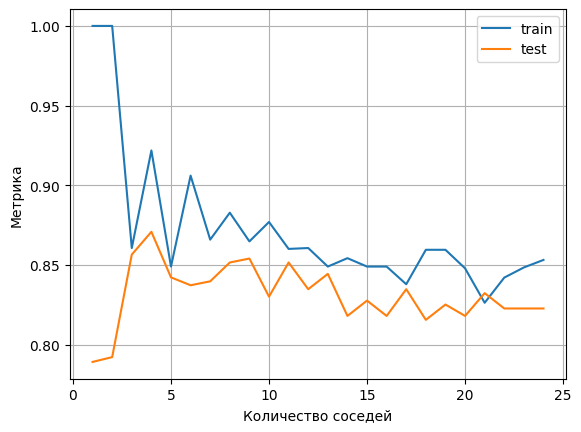

In [40]:
neigh = []

scores = [[], []]
score_train = []
score_test = []

model = KNNImplementation('mutable', cosine_distance)
model.fit(X_train, Y_train)
for n in range(1, 25):
    res = model.predict(X_test, uniform, n_neighbors=n)
    score_test.append(balanced_accuracy_score(Y_test, res))
    
    res = model.predict(X_train, gaussian_kernel, n_neighbors=n)
    score_train.append(balanced_accuracy_score(Y_train, res))
    
    neigh.append(n)
    
plt.plot(neigh, score_train)
plt.plot(neigh, score_test)
plt.grid(True)
plt.ylabel('Метрика')
plt.xlabel('Количество соседей')
plt.legend(['train', 'test'])
plt.show()

# Lowess my realization

In [44]:
model = KNNImplementation('mutable', cosine_distance)
weights = []

ker = uniform
neighbours_n = 20

for n in range(len(X_train)):
    tmp_y_test = Y_train[n]
    tmp_x_test = X_train[n]
    tmp_y_train = np.delete(Y_train, n, axis=0)
    tmp_x_train = np.delete(X_train, n, axis=0)
    
    model.fit(tmp_x_train, tmp_y_train)
    res = model.predict_one_iter(tmp_x_test, ker, n_neighbors=neighbours_n)
    
    err_coef = model.get_probabilities().get(tmp_y_test, 0.0)
    
    weights.append(err_coef)
weights_g = gaussian_kernel(np.array(weights))
weights_u = uniform(np.array(weights))
model.fit(X_train, Y_train)

res = model.predict(X_test, ker, n_neighbors=neighbours_n)
print("Ones", balanced_accuracy_score(Y_test, res))
res = model.predict(X_test, ker, n_neighbors=neighbours_n, weights=weights_g)
print("Gaussian", balanced_accuracy_score(Y_test, res))
res = model.predict(X_test, ker, n_neighbors=neighbours_n, weights=weights_u)
print("Uniform", balanced_accuracy_score(Y_test, res))

Ones 0.8181318681318681
Gaussian 0.8252747252747252
Uniform 0.8299450549450549


# Lib testing

[I 2024-03-25 01:02:32,727] A new study created in memory with name: no-name-b31d5ee2-5185-4273-9d3d-d84718fd535e


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-03-25 01:02:33,488] Trial 5 finished with value: 0.7946696696696697 and parameters: {'metrics': 'euclidean', 'neighbors': 16}. Best is trial 5 with value: 0.7946696696696697.
[I 2024-03-25 01:02:33,725] Trial 1 finished with value: 0.8224474474474475 and parameters: {'metrics': 'euclidean', 'neighbors': 17}. Best is trial 1 with value: 0.8224474474474475.
[I 2024-03-25 01:02:33,733] Trial 7 finished with value: 0.795045045045045 and parameters: {'metrics': 'euclidean', 'neighbors': 15}. Best is trial 1 with value: 0.8224474474474475.
[I 2024-03-25 01:02:33,738] Trial 4 finished with value: 0.8081831831831832 and parameters: {'metrics': 'euclidean', 'neighbors': 14}. Best is trial 1 with value: 0.8224474474474475.
[I 2024-03-25 01:02:33,760] Trial 0 finished with value: 0.795045045045045 and parameters: {'metrics': 'euclidean', 'neighbors': 13}. Best is trial 1 with value: 0.8224474474474475.
[I 2024-03-25 01:02:33,785] Trial 2 finished with value: 0.7665165165165165 and paramet

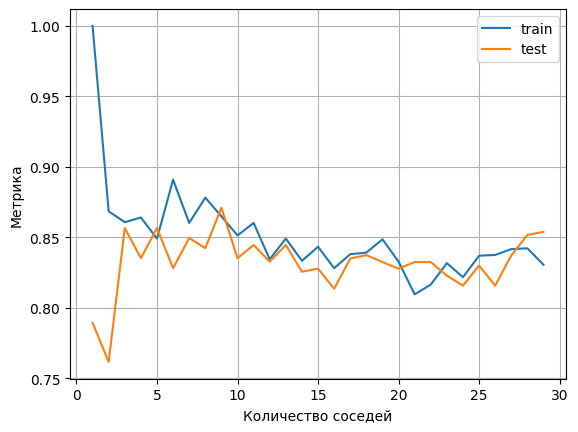

In [45]:
from sklearn.neighbors import KNeighborsClassifier

def opt_lib(trial: op.Trial) :
    Z_train, Z_test, v_train, v_test =\
        train_test_split(X_train, Y_train, test_size=TEST_SIZE, random_state=42)
    
    metrics = trial.suggest_categorical('metrics', ['euclidean', 'cosine', 'manhattan'])
    metric = CHOOSE_METRICS.get(metrics)
    
    neighbors = trial.suggest_int('neighbors', 2, 20)
    model = KNeighborsClassifier(n_neighbors=neighbors, metric=metric)
    model.fit(Z_train, v_train)
    
    return balanced_accuracy_score(v_test, 
                                   model.predict(Z_test))

study = op.create_study(direction='maximize')
study.optimize(opt_lib, n_jobs=-1, show_progress_bar=True, gc_after_trial=True,
               catch=RuntimeError, n_trials=1000)

print(study.best_params)
print(study.best_value)

neigh = []
score_train = []
score_test = []
for n in range(1, 30):
    model = KNeighborsClassifier(metric=cosine_distance, n_neighbors=n)
    model.fit(X_train, Y_train)
    
    res = model.predict(X_test)
    score_test.append(balanced_accuracy_score(Y_test, res))
    res = model.predict(X_train)
    score_train.append(balanced_accuracy_score(Y_train, res))
    
    neigh.append(n)

plt.plot(neigh, score_train)
plt.plot(neigh, score_test)
plt.grid(True)
plt.ylabel('Метрика')
plt.xlabel('Количество соседей')
plt.legend(['train', 'test'])
plt.show()

In [46]:
model = KNeighborsClassifier(n_neighbors=20, metric=cosine_distance)
weights = []
min_class = np.unique(Y_train)[0]
for n in range(len(X_train)):
    tmp_y_test = Y_train[n]
    tmp_x_test = X_train[n]
    tmp_y_train = np.delete(Y_train, n, axis=0)
    tmp_x_train = np.delete(X_train, n, axis=0)
    model.fit(tmp_x_train, tmp_y_train)
    res = model.predict_proba([tmp_x_test])[0]
    err_coef = res[tmp_y_test - min_class]
    weights.append(err_coef)
weights = np.array(weights)


def optLOWESS(trial: op.Trial) :
    kernels = trial.suggest_categorical('kernel', ['uniform', 'triangular', 'epanechnikov', 'gaussian'])
    
    kernel = KERNEL_METRICS.get(kernels) 
    
    tmp_weight = kernel(weights)
    bad_percintel = trial.suggest_float('percintel', 1e-3, 0.3)
    to_drop = []
    for it in range(len(tmp_weight)):
        if tmp_weight[it] <= bad_percintel:
            to_drop.append(it)
    tmp_y_train = np.delete(Y_train, to_drop, axis=0)
    tmp_x_train = np.delete(X_train, to_drop, axis=0)
    model = KNeighborsClassifier(n_neighbors=20, metric=cosine_distance)
    model.fit(tmp_x_train, tmp_y_train)
    res = model.predict(X_test)
    
    return balanced_accuracy_score(Y_test, res)
            
study = op.create_study(direction='maximize')
study.optimize(optLOWESS, n_jobs=-1, show_progress_bar=True, gc_after_trial=True, n_trials=600)

model.fit(X_train, Y_train)
res = model.predict(X_test)
print("Ones", balanced_accuracy_score(Y_test,  res))
print("Best founded: " + str(study.best_params) + " with value: " + str(study.best_value))

[I 2024-03-25 01:09:07,089] A new study created in memory with name: no-name-bf30a82e-a91f-4f0d-9813-96ae08c176d3


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2024-03-25 01:09:09,717] Trial 2 finished with value: 0.7541208791208791 and parameters: {'kernel': 'triangular', 'percintel': 0.19618651818776917}. Best is trial 2 with value: 0.7541208791208791.
[I 2024-03-25 01:09:10,268] Trial 7 finished with value: 0.8087912087912088 and parameters: {'kernel': 'triangular', 'percintel': 0.10233789489512894}. Best is trial 7 with value: 0.8087912087912088.
[I 2024-03-25 01:09:10,892] Trial 1 finished with value: 0.8541208791208792 and parameters: {'kernel': 'triangular', 'percintel': 0.0538841839198035}. Best is trial 1 with value: 0.8541208791208792.
[I 2024-03-25 01:09:11,135] Trial 4 finished with value: 0.8541208791208792 and parameters: {'kernel': 'epanechnikov', 'percintel': 0.11721055028257125}. Best is trial 1 with value: 0.8541208791208792.
[I 2024-03-25 01:09:11,412] Trial 6 finished with value: 0.8228021978021978 and parameters: {'kernel': 'uniform', 'percintel': 0.19750149333023695}. Best is trial 1 with value: 0.8541208791208792.
[I